The purpose of our project is to build a program that could read the expiration date from an image of a food product. As you will see from the examples below, the data that we used consisted of images of expiration dates on food products. 

You can connect this Google colab to your own Google drive, save the EAST detect neural network there, and replace the file paths used below with your own. Then try using our model to read text from your own images!

Enjoy!

-- Debbie Cohen & Talia Leitner

In [ ]:
%%capture
! sudo apt install tesseract-ocr
! pip install pillow
! pip install pytesseract
! pip install imutils
! pip install opencv-python
! pip install pyheif

In [ ]:
import cv2
import pytesseract
import imutils
from imutils.object_detection import non_max_suppression
import numpy as np
import os
import sys
import argparse
import time
import matplotlib.pyplot as plt

In [ ]:
# connecting to our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This algorithm uses the Open-CV EAST detection model. It returns the inputted image with boxes drawn aroud the text. It also returns an array with the coordinates of the text boxes.

In [ ]:
# using the Open-CV EAST detection model

def east_detect(image):
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    (H, W) = image.shape[:2]
    
    h = (H // 32) * 32
    w = (W // 32) * 32
    # set the new width and height and then determine the ratio in change
    # for both the width and height: should be multiple of 32
    (newW, newH) = (w, h)
    
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("/content/drive/MyDrive/Tamid_ML/frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    net.setInput(blob)
    
    # scores is the confidence of the geometric shapes
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
    		    # compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
    	# scale the bounding box coordinates based on the respective
    	# ratios 
    	startX = int(startX * rW)
    	startY = int(startY * rH)
    	endX = int(endX * rW)
    	endY = int(endY * rH)
    	# draw the bounding box on the image
    	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    
    return orig, boxes

**Working on image pre-processing:**

In [ ]:
# testing east detect model before pre-processing
path_str = "/content/drive/MyDrive/Tamid_ML/"
path = os.listdir(path_str)
i = 0
for filename in path:
  if '.jpeg' in filename or '.png' in filename:
    image = cv2.imread(path_str + filename)
    out_image, boxes = east_detect(image) 
    i+=1
    cv2.imwrite("sample" + str(i) + ".jpg", out_image) # save in colab

We found here that there are a couple of issues with the EAST detection model. Mainly, it has issues detecting text that is in dot matrix font. Additionally, it has issues detecting images that are rotated.

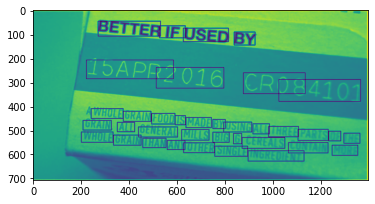

In [ ]:
# start playing around with pre processing - look into gray scaling, thresholding, bluring and sharpening
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_5.png") # choose an example image
arr = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # gray scaling
arr = cv2.blur(arr, (4,4)) # blurring
arr = cv2.GaussianBlur(arr, (3,3), 0) # further blurring
image, boxes = east_detect(arr) # test east detect
plt.imshow(image)

Here, we are introducing Pytesseract's OCR model to read the text from the above image. We extract one word at a time, based on the bounding boxes found above, and then convert the image's text into a string.

In [ ]:
# use pytesseract to read each of the boxes returned above
results = [] # text boxes extracted from image
text_results = [] # text
for box in boxes:
  (H, W) = image.shape[:2]
  h = (H // 32) * 32
  w = (W // 32) * 32
  (newW, newH) = (w, h)
  rW = W / float(newW)
  rH = H / float(newH)

  startY = int(box[1] * rH)
  startX = int(box[0] * rW)
  endY = int(box[3] * rH)
  endX = int(box[2] * rW)

  roi = arr[startY:endY, startX:endX]
  results.append(roi)

  text = pytesseract.image_to_string(roi, lang='eng', config='--psm 6')
  text_results.append(text)
text_results

['ANY\n\x0c',
 'BIG\n\x0c',
 'UORAIN\n\x0c',
 'WHOLE\n\x0c',
 'lHAN\n\x0c',
 'ALL\n\x0c',
 'UTHER\n\x0c',
 'USING\n\x0c',
 'BY\n\x0c',
 'GRAIN\n\x0c',
 'All\n\x0c',
 'ORAIN\n\x0c',
 'MADE\n\x0c',
 'OINGILE\n\x0c',
 'OCNERAL\n\x0c',
 'COREALS\n\x0c',
 'tHREE\n\x0c',
 'WHOLE\n\x0c',
 'IS\n\x0c',
 'OF\n\x0c',
 'MILLS\n\x0c',
 'FOOD\n\x0c',
 'MORE\n\x0c',
 'PARTS\n\x0c',
 'HE\n\x0c',
 'LCUNTAIN\n\x0c',
 'INGREDI Ew?\n\x0c',
 'BY\n\x0c',
 'BETTER\n\x0c',
 'USEN\n\x0c',
 'LOAPRs\n\x0c',
 '2016\n\x0c',
 'Chor Oh\n\x0c',
 '6\n\x0c',
 'CROR\n\x0c',
 'IE.\n\x0c']

We noted here that the text boxes were not returned in order.

In [ ]:
# can use this line of code to sort the boxes by y-coord and then x-coord
boxes = sorted(boxes, key = lambda x: [x[1], x[0]])
# can use this line of coded to join all of the text into a single string
results = " ".join(text_results)

Trying to solve the dot problem:

'Saagcaa seo Be)\n\x0c'

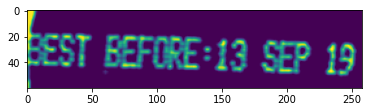

In [ ]:
# using blurring and sharpening to connect the dots in the text box
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_1.jpeg") # choose an example image
arr = image[70:130, 25:-10] # coords of text box
gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY) # gray scaling
arr = cv2.adaptiveThreshold(gray, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10) # thresholding black/white
arr = cv2.GaussianBlur(arr, (7, 7), 0) # blurring
kernell = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
arr = cv2.filter2D(src=arr, ddepth=-1, kernel=kernell) # sharpening
plt.imshow(arr)
text = pytesseract.image_to_string(arr)
text

Although Pytesseract doesn't do a great job at reading the text, the dots were successfully blurred together!

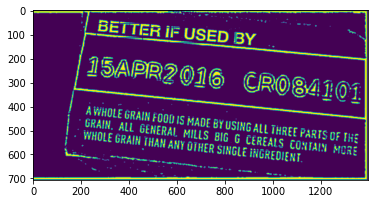

In [ ]:
# testing how this pre-processing works on images without dot matrix font
arr = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_5.png") # choose an example image
gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY) # gray scaling
arr = cv2.adaptiveThreshold(gray, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10) # thresholding black/white
arr = cv2.GaussianBlur(arr, (7, 7), 0) # blurring
kernell = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
arr = cv2.filter2D(src=arr, ddepth=-1, kernel=kernell) # sharpening
image, boxes = east_detect(arr) # test east detect
plt.imshow(image)

In [ ]:
# use pytesseract to read the text from the preprocessed image
boxes = sorted(boxes, key = lambda x: [x[1], x[0]])
for box in boxes:
  (H, W) = image.shape[:2]
  h = (H // 32) * 32
  w = (W // 32) * 32
  (newW, newH) = (w, h)
  rW = W / float(newW)
  rH = H / float(newH)

  startY = int(box[1] * rH)
  startX = int(box[0] * rW)
  endY = int(box[3] * rH)
  endX = int(box[2] * rW)

  roi = arr[startY:endY, startX:endX]
  results.append(roi)

  text = pytesseract.image_to_string(roi, lang='eng', config='--psm 6')
  text_results.append(text)

final_results = " ".join(text_results)
final_results

'ANY\n\x0c BIG\n\x0c UORAIN\n\x0c WHOLE\n\x0c lHAN\n\x0c ALL\n\x0c UTHER\n\x0c USING\n\x0c BY\n\x0c GRAIN\n\x0c All\n\x0c ORAIN\n\x0c MADE\n\x0c OINGILE\n\x0c OCNERAL\n\x0c COREALS\n\x0c tHREE\n\x0c WHOLE\n\x0c IS\n\x0c OF\n\x0c MILLS\n\x0c FOOD\n\x0c MORE\n\x0c PARTS\n\x0c HE\n\x0c LCUNTAIN\n\x0c INGREDI Ew?\n\x0c BY\n\x0c BETTER\n\x0c USEN\n\x0c LOAPRs\n\x0c 2016\n\x0c Chor Oh\n\x0c 6\n\x0c CROR\n\x0c IE.\n\x0c BETTER\n\x0c IE.\n\x0c USEN\n\x0c BY\n\x0c LOAPRs\n\x0c 2016\n\x0c CROR\n\x0c Chor Oh\n\x0c WHOLE\n\x0c GRAIN\n\x0c FOOD\n\x0c IS\n\x0c MADE\n\x0c BY\n\x0c UORAIN\n\x0c USING\n\x0c All\n\x0c ALL\n\x0c tHREE\n\x0c OCNERAL\n\x0c PARTS\n\x0c MILLS\n\x0c OF\n\x0c WHOLE\n\x0c BIG\n\x0c HE\n\x0c 6\n\x0c ORAIN\n\x0c COREALS\n\x0c lHAN\n\x0c ANY\n\x0c LCUNTAIN\n\x0c UTHER\n\x0c MORE\n\x0c OINGILE\n\x0c INGREDI Ew?\n\x0c lis 8)\n\x0c =" IF USED |\n\x0c WADED @\n\x0c SRY\n\x0c WHOLE\n\x0c ei\n\x0c a OFF)\n\x0c aR)\n\x0c MADE\n\x0c re ay\n\x0c OT USING\n\x0c rel\n\x0c ALL\n\x0c ra y.y\n\

We see here that the preprocessing also works for text that is not in dot matrix font!

Trying to solve the rotation problem:

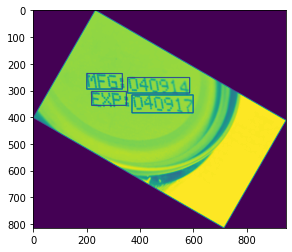

In [ ]:
# working on rotation - hard coding angle and testing with east detect
from scipy.ndimage import rotate
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_2.jpeg") # choose example image
image = rotate(image, -30)
arr = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # gray scaling
image, boxes = east_detect(cv2.blur(arr, (4,5))) # blurring
plt.imshow(image)

We found that the EAST detect algorithm works once the image is properly rotated! We want to find the threshold for how rotated an image can be and EAST detect to still work.

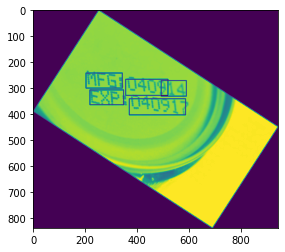

In [ ]:
# playing with threshold (correct is -30, can go until -33)
# can go 3 up
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_2.jpeg")
image = rotate(image, -33)
arr = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image, boxes = east_detect(cv2.blur(arr, (4,5)))
plt.imshow(image)

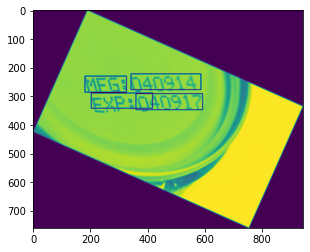

In [ ]:
# playing with threshold (corect is -30, can go until -24)
# can go 6 down
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_2.jpeg")
image = rotate(image, -24)
arr = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image, boxes = east_detect(cv2.blur(arr, (4,5)))
plt.imshow(image)

We see that the threshold is 9 degrees, 3 up and 6 down from the proper angle (0 degrees).

**Working on detecting the rotation angle: use a regression model!**

Our dataset was limited, so we needed to create an artificial dataset with rotations of our images.

Inspiration from:

https://stackoverflow.com/questions/58729151/why-is-my-convolutional-model-for-detecting-image-rotation-predicting-the-same-c

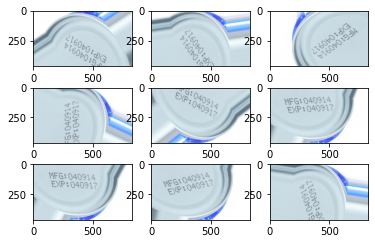

In [ ]:
# attempt to create a dataset for rotation model
# this example image is rotated by random degrees, 9 times, plus we have the original
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

images = []
rotations = []
# load the image
image = cv2.imread("/content/drive/MyDrive/Tamid_ML/exp_2.jpeg") # choose example
samples = expand_dims(image, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=180)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	rotations.append(batch)
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	results.append(image)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

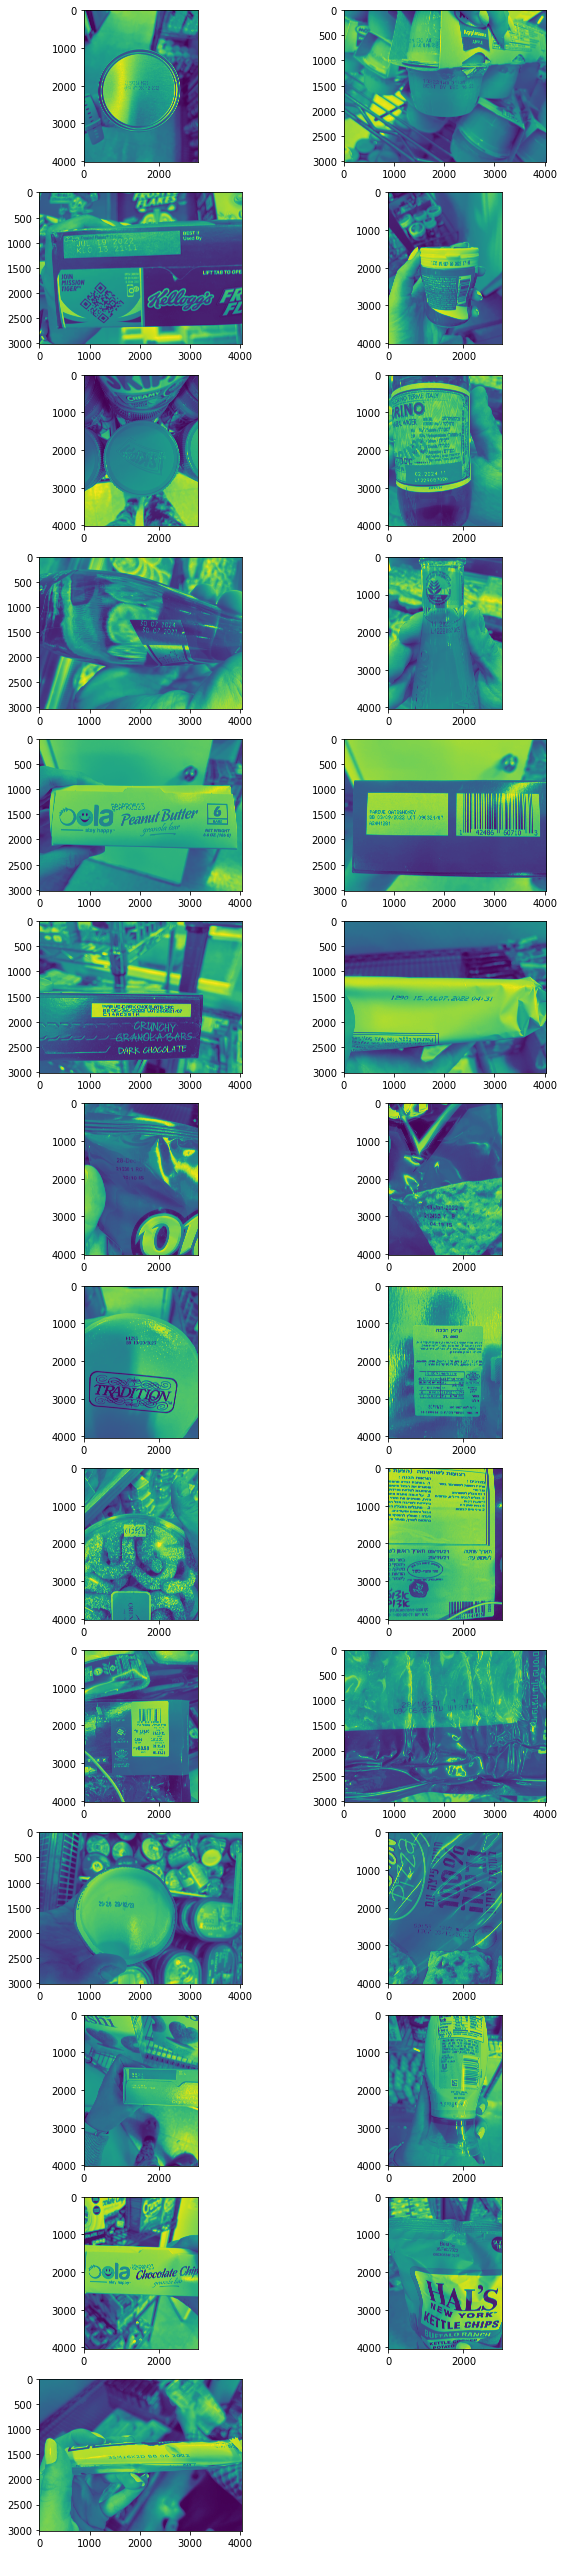

In [ ]:
# working on pre-processing for all images
path_str = "/content/drive/MyDrive/Rotation_Images/" # using our collected dataset (0 degrees rotation)
path = os.listdir(path_str)
images = []
n_image = 0
fig = plt.figure(figsize=(10,100))
for image in path:
  image = cv2.imread(path_str + image)
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scaling
  images.append(gray_img)
  plt.subplot(30,2,n_image+1)
  plt.imshow(gray_img)
  n_image+=1
plt.show()

In [ ]:
# now rotate and save the images and rotations
import random
rotations = []
new_images = []
n_image = 0
for image in images: # using pre-processed images from above
  n_image+=1
  print(n_image) # the number image we are up to (27 total)
  angles = [random.randint(0,180) for i in range(10)]
  rotations+=angles
  for i in range(10):
    new_images.append(rotate(image,angles[i]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


This above code takes a really long time, and many times has a runtime error. But we finally got it to work!

Started to work on regression model to predict rotation angle needed for image:

In [ ]:
# get the training, testing data - images are the data and rotations are the labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_images, rotations)

In [ ]:
# example labels
print(len(y_train), y_train)

202 [134, 86, 161, 103, 148, 61, 177, 49, 50, 148, 133, 168, 80, 24, 129, 152, 18, 83, 145, 66, 29, 124, 90, 38, 19, 115, 18, 88, 3, 2, 118, 10, 126, 101, 44, 1, 70, 149, 106, 36, 112, 148, 64, 169, 24, 115, 21, 150, 147, 30, 117, 20, 20, 44, 133, 176, 11, 10, 166, 60, 0, 14, 52, 51, 26, 75, 178, 24, 152, 175, 32, 0, 149, 124, 145, 107, 161, 0, 117, 87, 176, 19, 97, 133, 46, 78, 173, 164, 1, 64, 125, 9, 151, 125, 142, 41, 1, 5, 98, 56, 134, 143, 120, 128, 49, 139, 124, 83, 108, 165, 152, 15, 99, 0, 100, 2, 76, 120, 98, 90, 66, 54, 48, 86, 153, 45, 139, 85, 7, 67, 132, 149, 12, 149, 97, 122, 170, 0, 151, 102, 63, 71, 66, 19, 1, 20, 172, 38, 106, 77, 29, 94, 12, 84, 157, 173, 149, 2, 144, 171, 121, 129, 178, 166, 130, 24, 133, 65, 63, 80, 75, 80, 180, 29, 126, 142, 174, 96, 59, 98, 86, 163, 68, 79, 98, 11, 44, 149, 87, 104, 84, 125, 36, 40, 13, 175, 169, 89, 143, 98, 133, 81]


In [ ]:
# use keras to a build model for detecing the rotation angle
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(140, activation='relu'))
model.add(tf.keras.layers.Dense(180))

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test, y_test)

We could not successfully train this model because we didn't have enough data. We tried to use a classification model instead of regression, but didn't have enough photos for the 180 classes.

**Redefining our problem:**

Assuming images are rotated (and ignoring dot matrix font for now), we focused on
- Pre-processing
- EAST detection
- Reading each word with Pytesseract

See our Web App for how this all came together!